In [48]:
import json
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython.display import Image
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredDrawingArea
%matplotlib inline

In [2]:
cd ..

/Users/jacob/Documents/rurec


In [3]:
excluded_states = {'AK', 'PR', 'HI', 'VI'}
frac_fai_bins = [-0.01, 0.1, 0.3, 1]
frac_fai_labels = ['0 - 10%', '10 - 30%', '30 - 100%']

# Download geographic boundaries data
Census [Cartographic Boundary Shapefiles](https://www.census.gov/geo/maps-data/data/tiger-cart-boundary.html)

In [5]:
%%bash
OPWD=`pwd`
for ENTITY in csa cbsa; do
    FILE=cb_2017_us_${ENTITY}_500k.zip
    URL=https://www2.census.gov/geo/tiger/GENZ2017/shp/$FILE
    DIR=data/$ENTITY
    mkdir --parents $DIR
    cd $DIR
    wget --no-clobber --quiet $URL
    7z x $FILE > /dev/null
    cd $OPWD
    echo $FILE done.
done

cb_2017_us_csa_500k.zip done.
cb_2017_us_cbsa_500k.zip done.


mkdir: illegal option -- -
usage: mkdir [-pv] [-m mode] directory ...
bash: line 7: cd: data/csa: No such file or directory
bash: line 8: wget: command not found
bash: line 9: 7z: command not found
mkdir: illegal option -- -
usage: mkdir [-pv] [-m mode] directory ...
bash: line 7: cd: data/cbsa: No such file or directory
bash: line 8: wget: command not found
bash: line 9: 7z: command not found


# Employment data - InfoGroup

## Query and download raw data

In [ ]:
query = '''
SELECT
  state,
  substr(naics, 1, 6) as naics,
  employees,
  latitude,
  longitude
FROM
  `original.data`
where year = 2015;
'''
df = pd.read_gbq(query, dialect='standard', project_id='info-group-162919')
df.to_pickle('data/ig_2015.gz') # file compression

#4/AACH1S_uykkP6_cdDTdydYQik0aTXW5-v8XVhDdSI5rtQa2PIG5NcWw

In [4]:
df = pd.read_pickle('data/ig_2015.gz') 
df = df[~df.state.isin(excluded_states)]
df = df.drop('state', axis=1)
df.employees = pd.to_numeric(df.employees)
df = df.dropna(subset=['employees'])

## Identify non-farming FAI establishments

In [5]:
with open('data/fai.json') as f:
    fai_codes = json.load(f)
fainf_codes = {c: d for c, d in fai_codes.items() if c[:3] not in {'111', '112', '113', '114'}}
df['fai'] = df.naics.isin(fainf_codes)

In [6]:
pt = df.pivot_table('employees', 'fai', aggfunc=[pd.np.sum, pd.np.count_nonzero])
pt

sum count_nonzero
         employees     employees
fai                             
False  153966368.0    14076681.0
True     6759691.0      580999.0

In [7]:
pt / pt.sum()

sum count_nonzero
      employees     employees
fai                          
False  0.957943      0.960362
True   0.042057      0.039638

## Aggregate establishments into geographic bins for plotting

In [8]:
def expand_interval(df, col):
    for n in ['left', 'mid', 'right']:
        nn = col + '_' + n
        df[nn] = df[col]
        df[nn].cat.categories = df[col].cat.categories.__getattribute__(n)

In [9]:
n_lat = 400
df['blat'] = pd.cut(df.latitude, n_lat)
n_lon = 800
df['blon'] = pd.cut(df.longitude, n_lon)

In [10]:
dfb = df.drop(['latitude', 'longitude'], axis=1)
dfb = dfb.groupby(['blon', 'blat', 'fai'])
dfb = dfb.sum()
dfb = dfb.unstack('fai')

dfb = dfb.dropna(how='all')
dfb = dfb.fillna(0)
dfb.columns = ['emp_nonfai', 'emp_fai']

dfb = dfb.reset_index()
expand_interval(dfb, 'blat')
expand_interval(dfb, 'blon')

dfb['frac_fai'] = dfb.emp_fai / (dfb.emp_fai + dfb.emp_nonfai)
dfb['frac_fai_cat'] = pd.cut(dfb.frac_fai, frac_fai_bins)
dfb.frac_fai_cat.cat.categories = frac_fai_labels

In [11]:
dfb.frac_fai_cat.value_counts()

0 - 10%      75418
10 - 30%     11627
30 - 100%     8974
Name: frac_fai_cat, dtype: int64

## Demonstration of aggregation

This section demonstrates how multiple establishments are aggregated into a single bin.

In the figure below, 4 adjacent bins are shown. Establishments are drawn as circles, size show employment and color shows FAI or non-FAI.
A "plus" marker is in the middle of each bin, and is colored according to the total fraction of FAI employment in that bin.

In [200]:
show_lat_codes = [312, 313]
show_lon_codes = [447, 448]

blon              blat  emp_nonfai  emp_fai blat_left  \
44939  (-92.403, -92.331]   (43.89, 43.952]       106.0      4.0    43.890   
44940  (-92.403, -92.331]  (43.952, 44.014]       649.0     94.0    43.952   
45178  (-92.331, -92.259]   (43.89, 43.952]        33.0    700.0    43.890   
45179  (-92.331, -92.259]  (43.952, 44.014]        34.0      4.0    43.952   

      blat_mid blat_right blon_left blon_mid blon_right  frac_fai frac_fai_cat  
44939   43.921     43.952   -92.403  -92.367    -92.331  0.036364      0 - 10%  
44940   43.983     44.014   -92.403  -92.367    -92.331  0.126514     10 - 30%  
45178   43.921     43.952   -92.331  -92.295    -92.259  0.954980    30 - 100%  
45179   43.983     44.014   -92.331  -92.295    -92.259  0.105263     10 - 30%

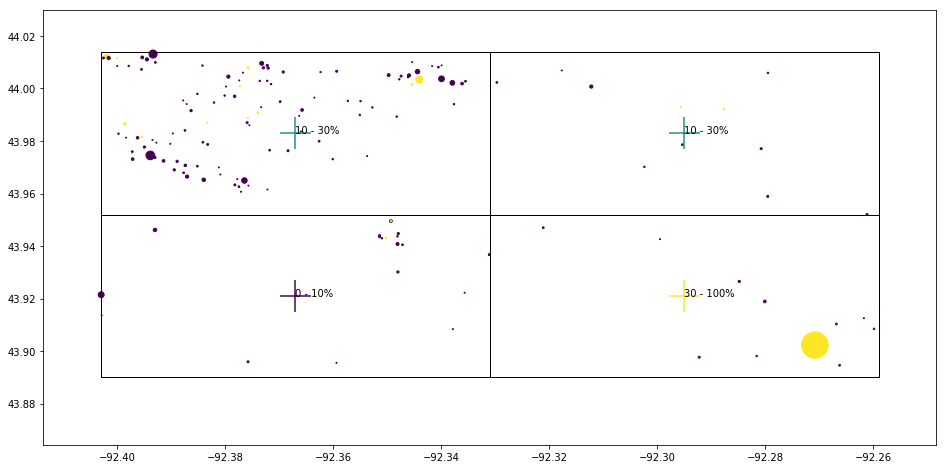

In [235]:
_df = df.loc[df.blat.cat.codes.isin(show_lat_codes) & df.blon.cat.codes.isin(show_lon_codes)].copy()
expand_interval(_df, 'blat')
expand_interval(_df, 'blon')
_, ax = plt.subplots(figsize=(16, 8))
ax.scatter(_df.longitude, _df.latitude, s=_df.employees, c=_df.fai)

_dfb = dfb[dfb.blon_mid.isin(_df.blon_mid.unique()) & dfb.blat_mid.isin(_df.blat_mid.unique())]
ax.scatter(_dfb.blon_mid, _dfb.blat_mid, s=1000, marker='+', c=_dfb.frac_fai_cat.cat.codes)

plt.plot()

for _, row in _dfb.iterrows():
    ax.annotate(row.frac_fai_cat, (row.blon_mid, row.blat_mid))
    r = mpl.patches.Rectangle(row[['blon_left', 'blat_left']], row.blon.length, row.blat.length, zorder=0, fill=False)
    ax.add_patch(r)
_dfb

blon_left   -92.331
blat_left    43.952
Name: 45179, dtype: object

# CBSA
[Definition](https://www.census.gov/geo/reference/gtc/gtc_cbsa.html):
> **Core Based Statistical Areas (CBSAs)** consist of the county or counties or equivalent entities associated with at least one core (urbanized area or urban cluster) of at least 10,000 population, plus adjacent counties having a high degree of social and economic integration with the core as measured through commuting ties with the counties associated with the core.  The general concept of a CBSA is that of a core area containing a substantial population nucleus, together with adjacent communities having a high degree of economic and social integration with that core.  The term "core based statistical area" became effective in 2003 and refers collectively to metropolitan statistical areas and micropolitan statistical areas.

In [12]:
# Refine for contiguous United States and reproject
path_shp = './data/cbsa/cb_2017_us_cbsa_500k.shp'
gdf = gpd.read_file(path_shp)
gdf['state'] = gdf.NAME.str.extract(', (.+)$')
gdf = gdf[~gdf.state.isin(excluded_states)]

cbsa_projected = gdf.to_crs({'init': 'epsg:6579'})

<h3>Convert aggregated points to geodataframe and reproject</h3>

In [25]:
longitudes = []
latitudes = []
for long in dfb['blon_mid']:
    longitudes.append(long)
for lat in dfb['blat_mid']:
    latitudes.append(lat)
    
frac_fai = []
frac_fai_cat = []
for fraction in dfb['frac_fai']:
    frac_fai.append(fraction)
for class_break in dfb['frac_fai_cat']:
    frac_fai_cat.append(class_break)
    
colors = []
for fraction in frac_fai:
    if fraction >= -0.10 and fraction <= 0.10:
        colors.append('#FF0808') # 0 - 10%
    elif fraction > 0.10 and fraction <= 0.30:
        colors.append('#F7FF00') # 10 - 30%
    elif fraction > 0.30 and fraction <= 1.1:
        colors.append('#29E2FF') # 30 - 100%

agg_points = gpd.GeoDataFrame()
agg_points['Coordinates'] = [[longitudes[i],latitudes[i]] for i in range(len(latitudes))] 
agg_points['frac_fai'] = frac_fai
agg_points['frac_fai_cat'] = frac_fai_cat
agg_points['color'] = colors

# assign point geometries to the geodataframe
agg_points.geometry = [Point(coordinate[0], coordinate[1]) for coordinate in agg_points['Coordinates']]
agg_points.crs = {'init': 'epsg:4326'}
agg_points = agg_points.to_crs({'init': 'epsg:6579'})

In [ ]:
# blue color: #0064DB
# yellow color: #F7FF00
# green color: #36FF22
# red color: #FF0808

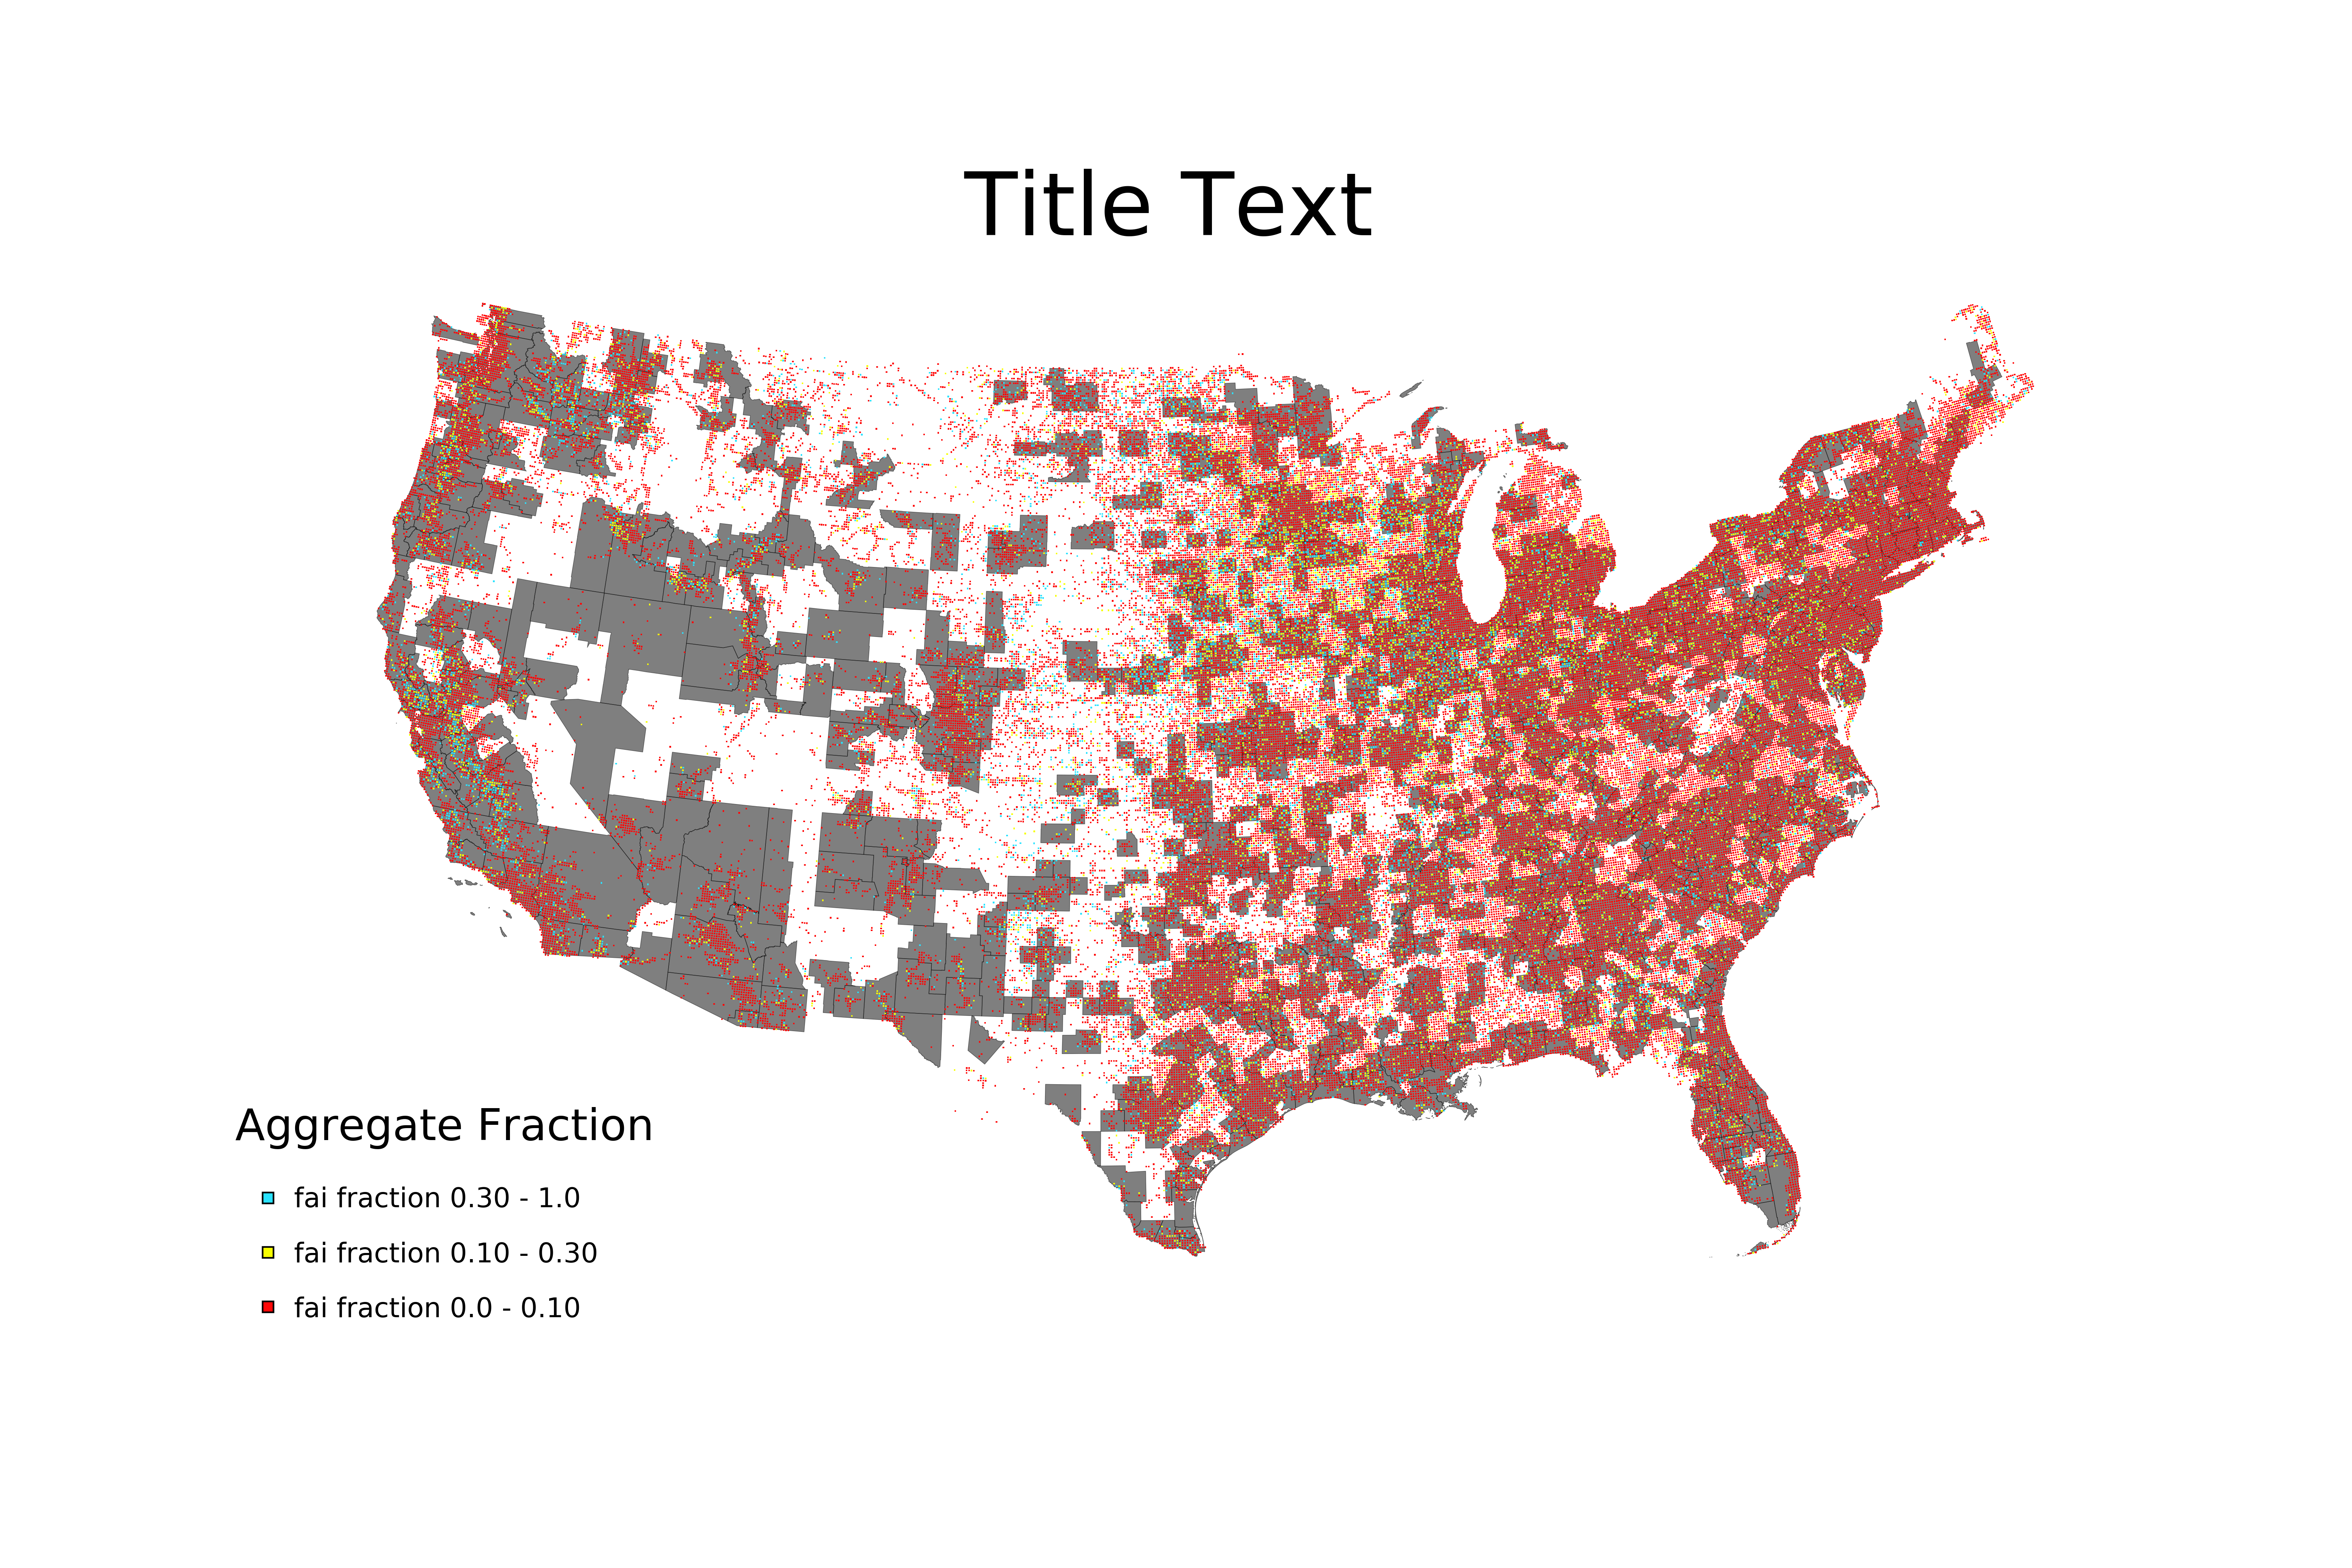

<Figure size 432x288 with 0 Axes>

In [67]:
ax = plt.axes()  # contiguous axis
ax.set_aspect('equal')
legend = plt.axes([0, 0.15, 0.1, 0.1]) # legend axis

ax.axis('off')
legend.axis('off')

# title
vert_pos = 7
horizontal_pos = 4.1
plt.text(horizontal_pos, vert_pos, 'Title Text', fontsize=16)

cbsa_projected.plot(ax=ax, facecolor='#000000', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
agg_points.plot(ax=ax, facecolor=agg_points['color'], edgecolor='none', markersize=0.085, marker='s')

# drawing area for legend squares
ada = AnchoredDrawingArea(0, 0, 0, 0, loc=1, pad=0., frameon=False)
first_break = Rectangle((10, 0), 2, fc='#29E2FF', ec='#000000', linewidth=0.3, height=2)
ada.drawing_area.add_artist(first_break)
second_break = Rectangle((10, -10), 2, fc="#F7FF00", ec='#000000', linewidth=0.3, height=2)
ada.drawing_area.add_artist(second_break)
third_break = Rectangle((10, -20), 2, fc="#FF0808", ec='#000000', linewidth=0.3, height=2)
ada.drawing_area.add_artist(third_break)
legend.add_artist(ada)

# legend text
legend.text(1, 1.23, 'Aggregate Fraction', fontsize=8)
legend.text(1.25, 0.80, 'fai fraction 0.30 - 1.0', fontsize=5)
legend.text(1.25, 0.45, 'fai fraction 0.10 - 0.30', fontsize=5)
legend.text(1.25, 0.10, 'fai fraction 0.0 - 0.10', fontsize=5)

plt.savefig('cbsa_fai.png', dpi=1080)
plt.clf() # clear the figure space
Image(filename="cbsa_fai.png")

# CSA
[Definition](https://www.census.gov/geo/reference/gtc/gtc_cbsa.html):
> **Combined Statistical Areas (CSAs)** consist of two or more adjacent CBSAs that have substantial employment interchange.  The CBSAs that combine to create a CSA retain separate identities within the larger CSA.  Because CSAs represent groupings of metropolitan and/or micropolitan statistical areas, they should not be ranked or compared with individual metropolitan and micropolitan statistical areas.

In [69]:
path_shp = './data/csa/cb_2017_us_csa_500k.shp'
gdf = gpd.read_file(path_shp)
gdf['state'] = gdf.NAME.str.extract(', (.+)$')
gdf = gdf[~gdf.state.isin(excluded_states)]

csa_projected = gdf.to_crs({'init': 'epsg:6579'})

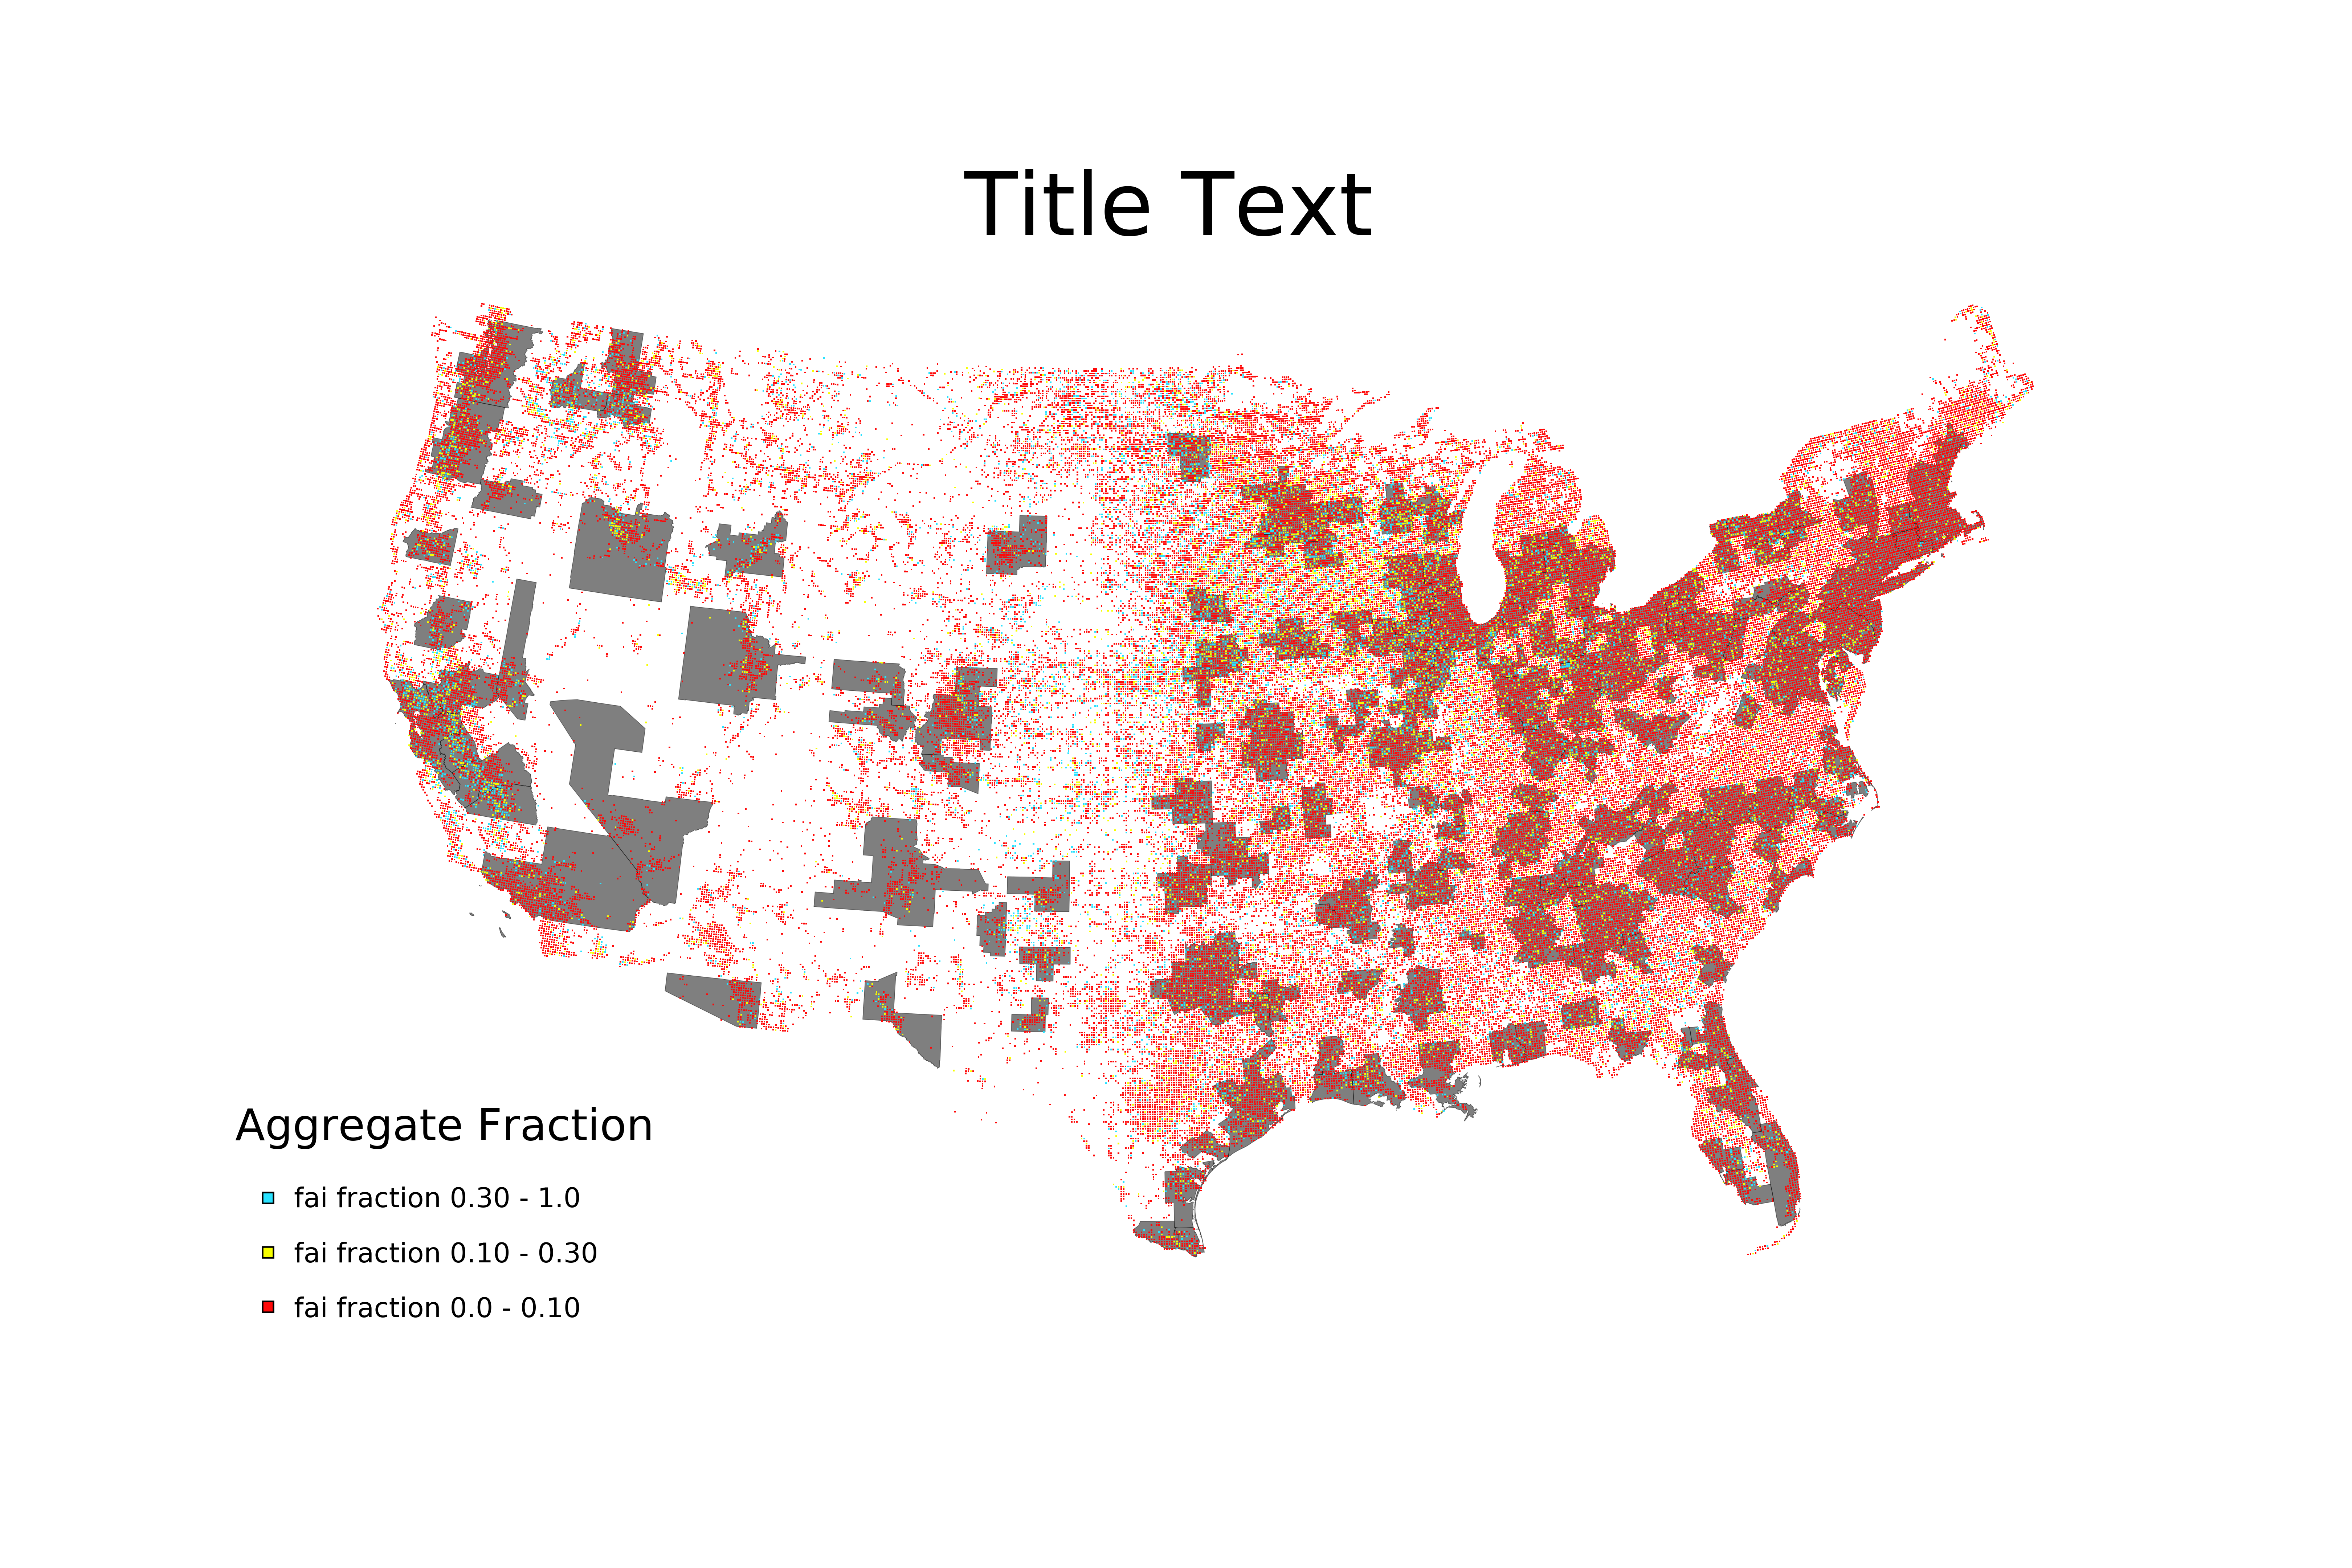

<Figure size 432x288 with 0 Axes>

In [70]:
ax = plt.axes()  # contiguous axis
ax.set_aspect('equal')
legend = plt.axes([0, 0.15, 0.1, 0.1]) # legend axis

ax.axis('off')
legend.axis('off')

# title
vert_pos = 7
horizontal_pos = 4.1
plt.text(horizontal_pos, vert_pos, 'Title Text', fontsize=16)

csa_projected.plot(ax=ax, facecolor='#000000', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
agg_points.plot(ax=ax, facecolor=agg_points['color'], edgecolor='none', markersize=0.085, marker='s')

# drawing area for legend squares
ada = AnchoredDrawingArea(0, 0, 0, 0, loc=1, pad=0., frameon=False)
first_break = Rectangle((10, 0), 2, fc='#29E2FF', ec='#000000', linewidth=0.3, height=2)
ada.drawing_area.add_artist(first_break)
second_break = Rectangle((10, -10), 2, fc="#F7FF00", ec='#000000', linewidth=0.3, height=2)
ada.drawing_area.add_artist(second_break)
third_break = Rectangle((10, -20), 2, fc="#FF0808", ec='#000000', linewidth=0.3, height=2)
ada.drawing_area.add_artist(third_break)
legend.add_artist(ada)

# legend text
legend.text(1, 1.23, 'Aggregate Fraction', fontsize=8)
legend.text(1.25, 0.80, 'fai fraction 0.30 - 1.0', fontsize=5)
legend.text(1.25, 0.45, 'fai fraction 0.10 - 0.30', fontsize=5)
legend.text(1.25, 0.10, 'fai fraction 0.0 - 0.10', fontsize=5)

plt.savefig('csa_fai.png', dpi=1080)
plt.clf() # clear the figure space
Image(filename="csa_fai.png")